In [49]:
import pandas as pd
import numpy as np
from pandas import DataFrame, to_datetime
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import pmdarima as pm
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
df1 = pd.read_csv('Table1.csv')
df2 = pd.read_csv('Table2.csv')

In [54]:
df1.drop(columns='Unnamed: 0',axis=0, inplace = True)
dft = df1.T
s1 = dft.stack()
year = s1.index.get_level_values(0).values
month = s1.index.get_level_values(1).values+1
year = year.astype(int)
month = month.astype(int)
s1.index = pd.PeriodIndex(year=year, month=month, freq='M')
s1 = pd.DataFrame(s1)
s1.index = s1.index.astype('datetime64[ns]') 
s1 = s1.set_axis(['value'], axis='columns')

In [55]:
df2.drop(columns='Unnamed: 0',axis=0, inplace = True)
dft2 = df2.T
s2 = dft2.stack()
year = s2.index.get_level_values(0).values
month = s2.index.get_level_values(1).values+1
year = year.astype(int)
month = month.astype(int)
s2.index = pd.PeriodIndex(year=year, month=month, freq='M')
s2 = pd.DataFrame(s2)
s2.index = s2.index.astype('datetime64[ns]') 
s2 = s2.set_axis(['value2'], axis='columns')

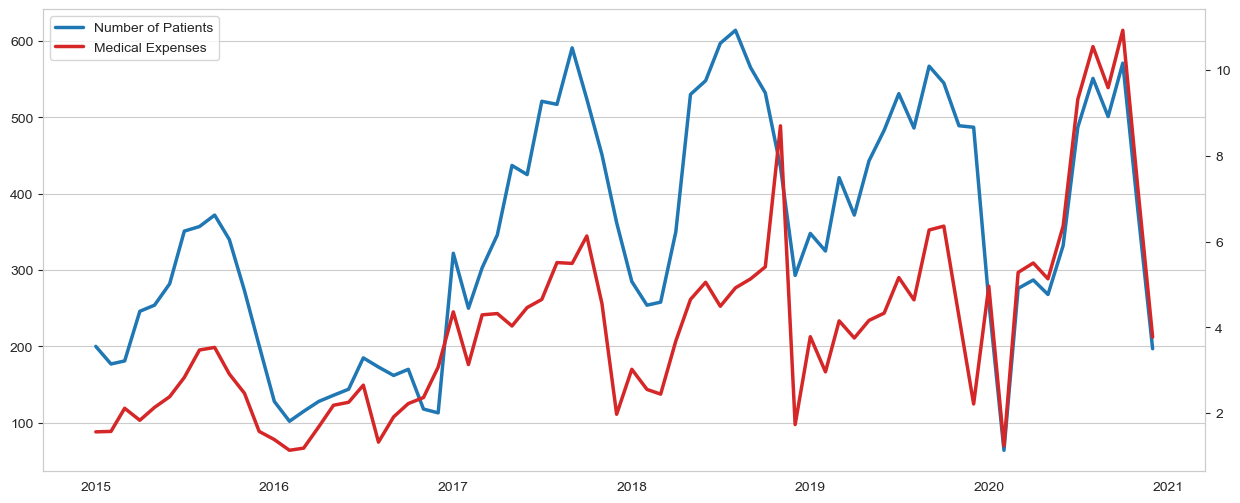

In [56]:
fig, ax1 = plt.subplots(figsize=(15, 6))
sns.set_style("whitegrid")
ax2 = ax1.twinx()
l1, = ax1.plot(s1.value, label = 'label1', color='tab:blue', linewidth=2.5)
l2, = ax2.plot(s2.value2, label = 'label2', color='tab:red', linewidth=2.5)
plt.legend([l1, l2],['Number of Patients', 'Medical Expenses'])
ax2.yaxis.grid(False)
ax1.xaxis.grid(False)
plt.plot()
plt.show()

In [57]:
S = s1

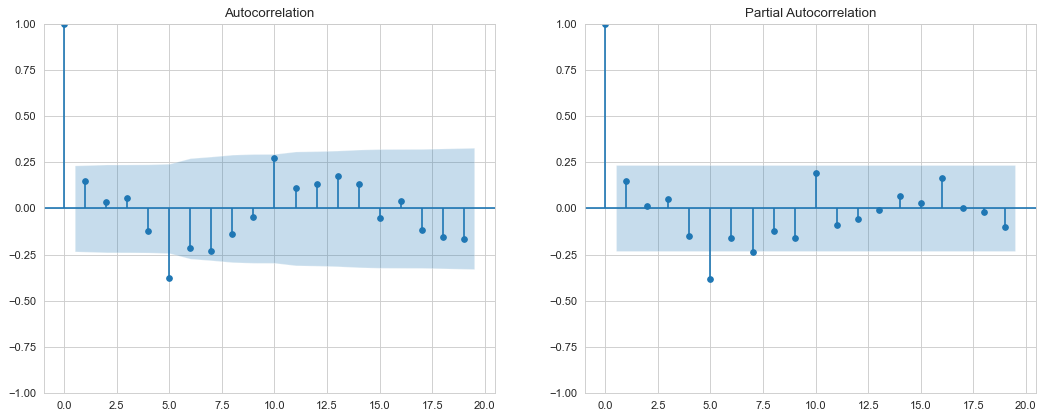

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(S.diff().dropna(), ax=ax1)
plot_pacf(S.diff().dropna(), ax=ax2);

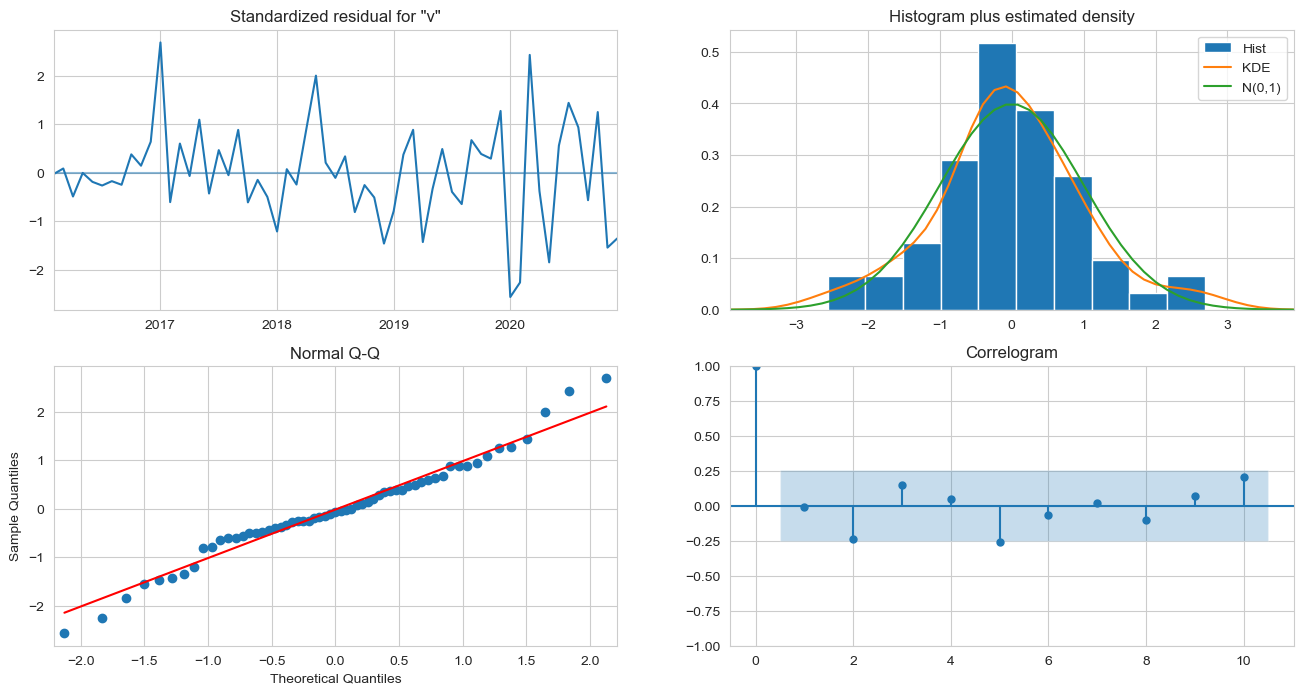

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      value   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -342.486
Date:                                    Mon, 30 Jan 2023   AIC                            698.972
Time:                                            08:04:40   BIC                            713.515
Sample:                                        01-01-2015   HQIC                           704.649
                                             - 12-01-2020                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0131      0.121     -0.108      0.914      -0.251       0.224
ar.S.L12       0.1359      0.489      0.278      0.781      -0.823       1.095
ar.S.L24       0.8334      1.510      0.552      0.581      -2.126       3.792
ma.S.L12      -0.9275      0.449     -2.067      0.039      -1.807      -0.048
ma.S.L24      -0.3895      1.421     -0.274      0.784      -3.175       2.396
ma.S.L36       0.3033      1.594      0.190      0.849      -2.821       3.428
sigma2      5334.9203   8.84e-05   6.03e+07      0.000    5334.920    5334.921
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.93   Prob(JB):                         0.48
Heteroskedasticity (H):               2.98   Skew:                             0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.77e+24. Standard errors may be unstable.
"""

In [59]:
pd.plotting.register_matplotlib_converters()
model = SARIMAX(S,
                order=(1, 1, 0),  
                seasonal_order=(2, 1, 3, 12), 
                enforce_invertibility=False,
                )
results = model.fit()
results.plot_diagnostics(figsize=(16, 8))
plt.show()
results.summary()

Text(0, 0.5, 'N.PatiEnts')

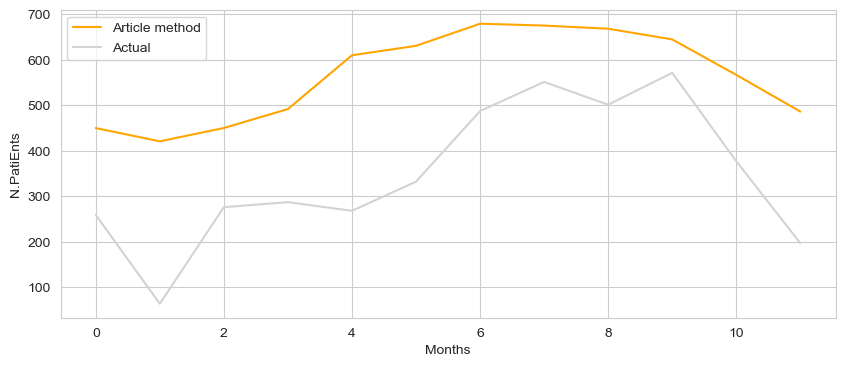

In [60]:
y_to_train = S.loc['2015-01-1':'2019-12-01']
y_to_test = S.loc['2020-01-1':]
train_len = len(y_to_train)
results = model.fit()
pred_dynamic = results.get_prediction(start=train_len, dynamic=True)
Y_pred1 = np.array(pred_dynamic.predicted_mean)
Y_true = np.array(y_to_test)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,4)
plt.plot(Y_pred1, label="Article method", color="orange")
plt.plot(Y_true, label="Actual", color="lightgray")
plt.legend(loc="best")
plt.xlabel('Months', fontsize=10)
plt.ylabel('N.PatiEnts', fontsize=10)

In [61]:
#ARIMA
S = s1
y_to_train = S.loc['2015-01-1':'2019-12-01']
y_to_test = S.loc['2020-01-1':]
train_len=len(y_to_train)

model = pm.auto_arima(y_to_train, 
                      seasonal=True, m=12,
                      d=0, D=1, 
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      stepwise=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      ) 
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=630.303, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=540.726, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=632.077, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=567.548, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=536.599, Time=0.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=590.483, Time=0.54 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=537.371, Time=0.96 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=537.730, Time=0.93 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=560.533, Time=0.73 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=535.789, Time=1.25 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=537.55

Text(0, 0.5, 'N.PatiEnts')

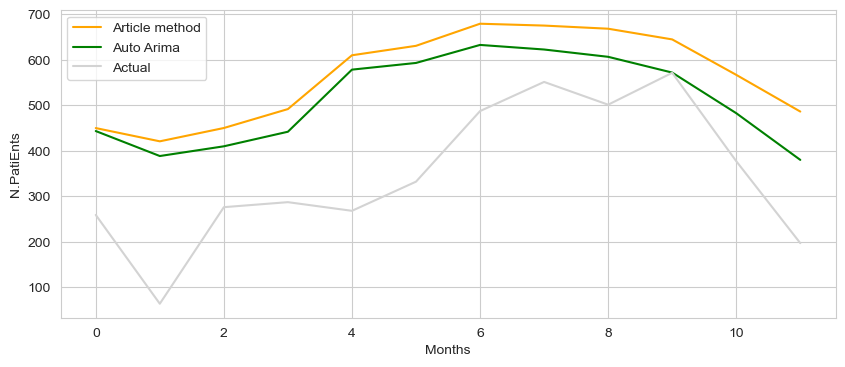

In [62]:
model = SARIMAX(S,
                order=(2, 0, 1),  
                seasonal_order=(2, 1, 0, 12), 
                enforce_invertibility=False,
                )
results = model.fit()
pred_dynamic = results.get_prediction(start=train_len, dynamic=True)
Y_pred11 = np.array(pred_dynamic.predicted_mean)
Y_true = np.array(y_to_test)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,4)
plt.plot(Y_pred1, label="Article method", color="orange")
plt.plot(Y_pred11, label="Auto Arima ", color="green")
plt.plot(Y_true, label="Actual", color="lightgray")
plt.legend(loc="best")
plt.xlabel('Months', fontsize=10)
plt.ylabel('N.PatiEnts', fontsize=10)


In [63]:
#LSTM
S = s1
train = S.loc['2015-01-1':'2019-12-01']
test = S.loc['2020-01-1':]
train_len = len(train)

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

n_input = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=3)

model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer= Adam(learning_rate = 0.01), loss='mae')
model.summary()
model.fit_generator(generator,epochs=100)
model.history.history.keys()
loss_per_epoch = model.history.history['loss']

first_eval_batch = scaled_train[-12:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
Y_true = test['value']
Y_pred3 = test["Predictions"]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 7ms/step - loss: 0.2958
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.3367
Epoch 3/100
16/16 [=======

16/16 [==============================] - 0s 8ms/step - loss: 0.1119
Epoch 91/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1174
Epoch 92/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1438
Epoch 93/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1137
Epoch 94/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1145
Epoch 95/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1333
Epoch 96/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1142
Epoch 97/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1166
Epoch 98/100
16/16 [==============================] - 0s 7ms/step - loss: 0.1260
Epoch 99/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1174
Epoch 100/100
1/1 [==============================] - 0s 21ms/step


In [ ]:
Y_save_LSTM = [412.20632935, 371.08343506, 340.97789001, 359.18930054,
       413.65722656, 428.65966797, 478.38781738, 501.86657715,
       496.41278076, 455.30493164, 384.4850769 , 305.01582336]

08:05:37 - cmdstanpy - INFO - Chain [1] start processing
08:05:37 - cmdstanpy - INFO - Chain [1] done processing


MAE: 181.020


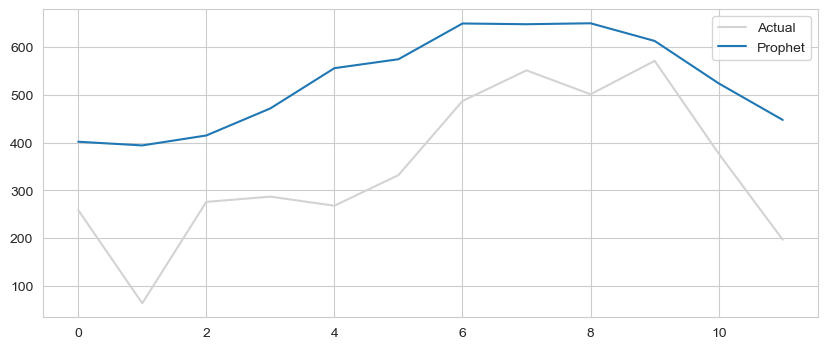

In [64]:
#FB.Prophet
S = s1
Strain = S.loc['2015-01-1':'2019-12-01']
Stest = S.loc['2020-01-1':]

# prepare expected column names
S['ds'] = S.index
S.rename(columns = {'value':'y'}, inplace = True)
# create test dataset, remove last 12 months
train = S.drop(S.index[-12:])
# define the model
model = Prophet()
# fit the model
model.fit(train)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2020-%02d' % i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# calculate MAE between expected and predicted values for december
Y_true = S['y'][-12:].values
Y_pred2 = forecast['yhat'].values
mae = mean_absolute_error(Y_true, Y_pred2)
print('MAE: %.3f' % mae)
# plot expected vs actual

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,4)
pyplot.plot(Y_true, label='Actual', color="lightgray")
pyplot.plot(Y_pred2, label='Prophet', color="tab:blue")
pyplot.legend()
pyplot.show()

In [66]:
#Y_true.reset_index(drop=True, inplace=True)
Y_pred3.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'Demand')

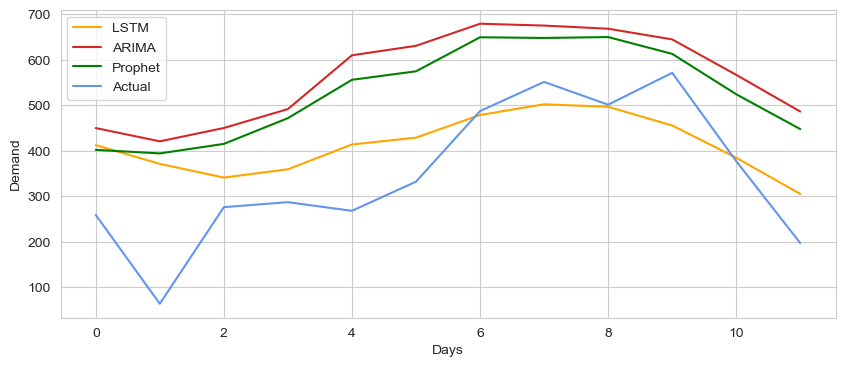

In [69]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10,4)
plt.plot(Y_save_LSTM, label="LSTM", color="orange")
plt.plot(Y_pred1, label="ARIMA", color="tab:red")
plt.plot(Y_pred2, label="Prophet", color="green")
plt.plot(Y_true, label="Actual", color="cornflowerblue")
plt.legend(loc="best")
plt.xlabel('Days', fontsize=10)
plt.ylabel('Demand', fontsize=10)

In [78]:
mae1 = mean_absolute_error(Y_true, Y_save_LSTM)
mae2 = mean_absolute_error(Y_true, Y_pred11)
mae3 = mean_absolute_error(Y_true, Y_pred2)

In [87]:
mae1, mae2, mae3

(94.44188690166668, 164.79951819992024, 181.01961831189132)

In [81]:
rms1 = sqrt(mean_squared_error(Y_true, Y_save_LSTM))
rms2 = sqrt(mean_squared_error(Y_true, Y_pred11))
rms3 = sqrt(mean_squared_error(Y_true, Y_pred2))

In [88]:
rms1, rms1, rms1

(124.29234846084101, 124.29234846084101, 124.29234846084101)